# Modelos de lenguaje neuronales

In [1]:
import pandas as pd
import torch
from NLPUtils import *
import re
import fasttext

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

Vamos a definir que un modelo de lenguaje sobre un vocabulario $V = \{ p_1, \ldots, p_{|V|}\}$ es la capacidad de asignarle una probabilidad $P(w_1,\ldots,w_n)$ a cada conjunto de palabras $w_1,\ldots,w_n$ pertenecientes al vocabulario $V$.

Para calcular esa probabilidad suele hacerse un modelo de N-gramas, en que vale la aproximación

$$
\begin{align*}
P(w_1,\ldots,w_n) &= P(w_n|w_{n-1},\ldots,w_1) P(w_{n-1}|w_{n-2},\ldots,w_1)\ldots P(w_2|w_1) P(w_1)\\[.5em]
&= \prod_{i=1}^n P(w_i|w_{i-1},\ldots,w_1)\\[.5em]
&\approx \prod_{i=1}^n P(w_i|w_{i-1},\ldots,w_{i-N+1})\\
\end{align*}
$$

Ahora, para estimar estas probabilidades, pueden usarse métodos distintos. Uno de ellos consiste en estimar por métodos frecuentistas estas probabilidades:

$$
P(w_i|w_{i-1},\ldots,w_{i-N+1}) = \frac{C(w_i,\ldots,w_{i-N+1})}{C(w_{i-1},\ldots,w_{i-N+1})}
$$

Otro de estos métodos consiste en modelar la probabilidad $P(w_i|w_{i-1},\ldots,w_{i-N+1})$ con una red neuronal y entrenar sus parámetros con algún modelo (por ejemplo, word2vec).

Para medir si un modelo de lenguaje es bueno, suele utilizarse la perplejidad sobre un corpus determinado. Si se tiene que ese corpus contiene $M$ palabras $w_1, \ldots, w_m$ pertenecientes a un vocabulario $V$, la perplejidad se define como

$$
Per(w_1,\ldots,w_m) = \left(\frac{1}{P(w_1,\ldots,w_m)} \right)^{1/M}
$$

y si se tiene un modelo de N-gramas, esta fórmula se convierte en:

$$
Per(w_1,\ldots,w_m) = \left(\prod_{i=1}^M\frac{1}{P(w_i|w_{i-1},\ldots,w_{1-N+1})} \right)^{1/M}
$$

## Modelo de lenguaje frecuentista

El archivo `lm_l40` contiene la información del modelo de lenguaje estimado para un modelo de bigramas con el set de entrenamiento de la base de datos Latino-40. Con este dato, calculamos la perplejidad de este modelo de lenguaje sobre las frases de test.

In [2]:
# Obtenemos el modelo de lenguaje del método frecuentista:
with open('lm_l40', 'rb') as file:
    lines = [line.decode('iso-8859-1') for line in file]
    idx = lines.index('\\data\\\n') + 1
    line = lines[idx]
    ngrams_len = []
    log_probs = []
    while line[:5] == 'ngram':
        ngrams_len.append(int(line.split('=')[1][:-1]))
        idx += 1
        line = lines[idx]
    N = len(ngrams_len)
    for i in range(1,N+1):
        idx = lines.index('\\{}-grams:\n'.format(i)) + 1
        lp = {re.split(r'[\t\n]',lines[j])[1]: float(lines[j].split('\t')[0]) for j in range(idx,idx+ngrams_len[i-1])}
        log_probs.append(lp)
        
# Juntamos el corpus de test en una sola lista:
with open('promptsl40.test','rb') as file:
    test_lines = file.readlines()
    test_lines = [' '.join(re.findall(r'\w+',line.decode('iso-8859-1'))[1:]) for line in test_lines]
    corpus_test = [line.split(' ') for line in test_lines]
    corpus_test = [word for line in corpus_test for word in line]

In [51]:
# Perplejidad para un modelo de bigrama:
corpus_len = len(corpus_test)
p = log_probs[0][corpus_test[0]]
for idx in range(1,corpus_len):
    p += log_probs[1]['{} {}'.format(corpus_test[idx],corpus_test[idx-1])]
print('El logaritmo de la perplejidad para el corpus de test es: {}'.format(p))

KeyError: 'jugará no'

## Modelo de lenguaje neuronal

Cargamos el corpus de texto, conformado por todas las frases del conjunto de train.

In [3]:
with open('trainLM.txt', 'rb') as file:
    lines = file.readlines()
    corpus = [line.decode('iso-8859-1').split(' ')[:-1] for line in lines]
    
print('Mostramos las primeras 10 frases del corpus:')
for i in range(10):
    print(corpus[i])

Mostramos las primeras 10 frases del corpus:
['no', 'habiendo', 'objeciones', 'así', 'quedó', 'acordado']
['a', 'fin', 'de', 'año', 'hará', 'el', 'balance', 'de', 'la', 'situación']
['este', 'programa', 'debe', 'ejecutarse', 'en', 'todos', 'los', 'niveles']
['no', 'debe', 'interpretarse', 'esto', 'como', 'que', 'uno', 'es', 'más', 'rico']
['la', 'pareja', 'partió', 'esta', 'madrugada', 'para', 'la', 'capital']
['a', 'la', 'sazón', 'los', 'locales', 'no', 'disfrutaban', 'de', 'inviolabilidad']
['la', 'princesa', 'del', 'japón', 'niega', 'que', 'esté', 'embarazada']
['la', 'esposa', 'y', 'su', 'hija', 'estaban', 'con', 'el', 'cantante', 'en', 'roma']
['ninguno', 'de', 'los', 'ataques', 'causó', 'daños', 'ni', 'heridos']
['esto', 'dio', 'lugar', 'a', 'que', 'se', 'reabrieran', 'ciertos', 'casos']


In [4]:
corpus = [token for doc in corpus for token in doc]

In [5]:
window_size = 8           # Tamaño de la ventana del contexto.
cutoff_freq = 0           # Palabras con una frecuencia menor o igual a cutoff_freq son excluídas del vocabulario.
batch_size = 512          # Tamaño del batch.

model = 'SkipGram'        # Método de entrenamiento.
embedding_dim = 200       # Dimensión del espacio de los word vectors.
device = 'cpu'            # Dispositivo sobre el cual se entrena. 
state_dict = None         # Parámetros pre-entrenados.
paralelize = False        # Flag para decirle al programa que use las 2 gpus

epochs = 100              # Cantidad de epochs
learning_rate = 1e-4      # Tasa de aprendizaje
sample_loss_every = 10    # Calcular la loss cada este número
algorithm = 'Adam'        # Algoritmo de optimización

trainer = Word2vecTrainer(corpus,cutoff_freq=cutoff_freq,window_size=window_size,batch_size=batch_size)
trainer.InitModel(model=model, state_dict=state_dict, device=device, paralelize=paralelize, embedding_dim=embedding_dim)
trainer.Train(algorithm=algorithm, epochs=epochs, sample_loss_every=sample_loss_every, lr=learning_rate)

Word2vec trainer created:
Window size: 8
Number of samples: 154775
Vocabulary Size: 31
Number of batches: 303
Number of samples per batch: 512

Dispositivo seleccionado: cpu
Dimensión del espacio de los embeddings: 200
Starting training...
Optimization method: Adam
Learning Rate: 0.0001
Number of epochs: 100
Running on device (cpu)

Epoch: 1, Batch number: 0, Loss: 10570.8994140625
Epoch: 1, Batch number: 10, Loss: 9859.0986328125
Epoch: 1, Batch number: 20, Loss: 9914.5302734375
Epoch: 1, Batch number: 30, Loss: 10184.130859375
Epoch: 1, Batch number: 40, Loss: 9726.2333984375
Epoch: 1, Batch number: 50, Loss: 9644.0703125
Epoch: 1, Batch number: 60, Loss: 9609.8984375
Epoch: 1, Batch number: 70, Loss: 9753.1953125
Epoch: 1, Batch number: 80, Loss: 9428.8583984375
Epoch: 1, Batch number: 90, Loss: 9175.0654296875
Epoch: 1, Batch number: 100, Loss: 9474.1435546875
Epoch: 1, Batch number: 110, Loss: 9021.431640625
Epoch: 1, Batch number: 120, Loss: 9243.318359375
Epoch: 1, Batch number:

<IPython.core.display.Javascript object>


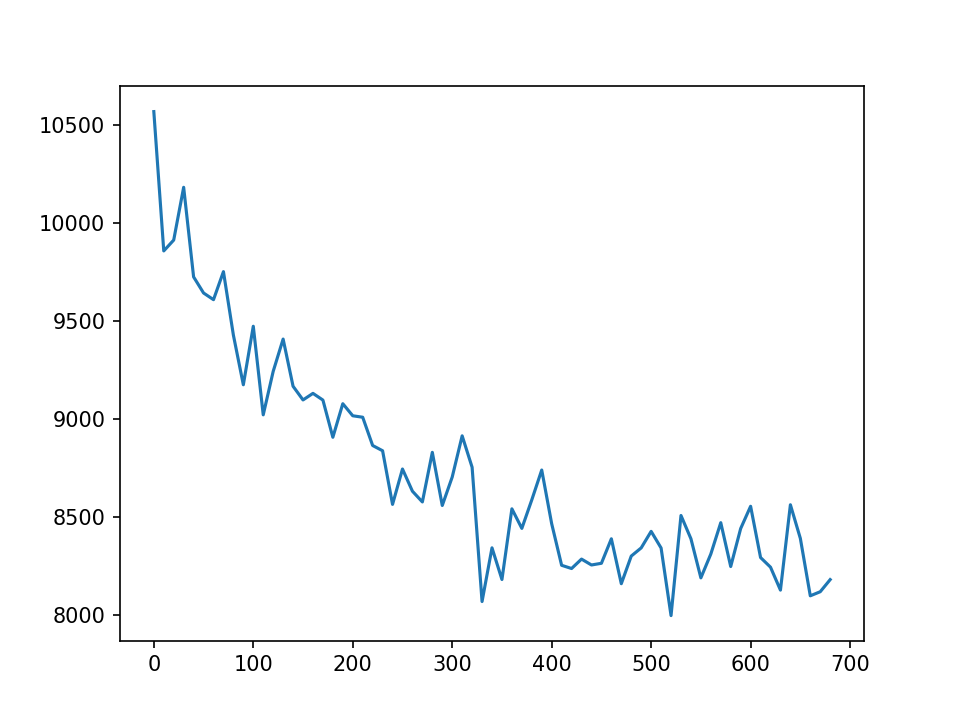

In [6]:
fig, ax = plt.subplots()
ax.plot(trainer.loss_history['iter'],trainer.loss_history['loss'])

In [7]:
# Perplejidad para un modelo de bigrama:
corpus_len = len(corpus_test)
vocab = Vocabulary.from_corpus([corpus_test])
activation = nn.LogSoftmax()
for idx in range(1,corpus_len):
    x = torch.tensor(vocab[corpus_test[idx]],device=torch.device(device))
    log_probs = activation(trainer.model(x))
    print(log_probs)

RuntimeError: index out of range: Tried to access index 1434 out of table with 31 rows. at /opt/conda/conda-bld/pytorch_1570910687650/work/aten/src/TH/generic/THTensorEvenMoreMath.cpp:418